## RLlib PPO policy evaluation

In [1]:
import gym
import ray
from ray.tune.registry import register_env
from ray.rllib.agents import ppo
from ray import serve

In [2]:
ray.init()

2022-07-06 17:25:49,455	INFO services.py:1456 -- View the Ray dashboard at http://127.0.0.1:8265


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.8.12', ray_version='1.12.0', ray_commit='f18fc31c7562990955556899090f8e8656b48d2d', address_info={'node_ip_address': '127.0.0.1', 'raylet_ip_address': '127.0.0.1', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-07-06_17-25-47_173302_45621/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-07-06_17-25-47_173302_45621/sockets/raylet', 'webui_url': '127.0.0.1:8265', 'session_dir': '/tmp/ray/session_2022-07-06_17-25-47_173302_45621', 'metrics_export_port': 60817, 'gcs_address': '127.0.0.1:64671', 'address': '127.0.0.1:64671', 'node_id': 'f11f772259e1920b16ac3af372dc47847c0c5d7f31d02cc30a4d410e'})

In [3]:
from config import Config
from data_prep import DataPrep
from env import CMAPSSEnv
from VAE_dense import *
from tf_serve_models import TFEncoderDecoderModel

# Load options
serve.start()
TFEncoderDecoderModel.deploy(['./saved_models/encoder','./saved_models/decoder'])

const = Config()
neurons = const.VAE_neurons

# Data prep
# Load the 3rd batch of data which are for policy evaluation
data = DataPrep(file = const.file_path,
                num_settings = const.num_settings,
                num_sensors = const.num_sensors,
                num_units = const.num_units[2],
                prev_step_units = const.prev_step_units[2],
                step = const.step[2],
                normalization_type="01")

df = data.ReadData()
#print(df)

# List of engine lifetimes
engine_lives = df.groupby(df['Unit']).size()
engine_lives = engine_lives.tolist()
num_engines = len(engine_lives)

# Environment types
env_types = ["batch", "intertemporal"]

##########################################
env_config = {
    "df": df,
    "timestep": 0,
    "obs_size": const.num_settings+const.num_sensors+1,
    "engines": num_engines,
    "engine_lives": engine_lives, 
    "models": [None, None],
    "env_type": env_types[1],
}

env_name = "CMAPSS_env"
env_wrapper_config = gym.wrappers.FrameStack(CMAPSSEnv(**env_config), const.num_frames)
register_env(env_name, lambda config: env_wrapper_config)

(ServeController pid=45677) 2022-07-06 17:25:54,935	INFO checkpoint_path.py:15 -- Using RayInternalKVStore for controller checkpoint and recovery.
(ServeController pid=45677) 2022-07-06 17:25:55,040	INFO http_state.py:106 -- Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:oIBMAf:SERVE_PROXY_ACTOR-node:127.0.0.1-0' on node 'node:127.0.0.1-0' listening on '127.0.0.1:8000'
2022-07-06 17:25:55,813	INFO api.py:794 -- Started Serve instance in namespace '9459bec7-0b86-4ad2-a562-272a9e2037bf'.
2022-07-06 17:25:55,825	INFO api.py:615 -- Updating deployment 'TFEncoderDecoderModel'. component=serve deployment=TFEncoderDecoderModel
(ServeController pid=45677) 2022-07-06 17:25:55,871	INFO deployment_state.py:1210 -- Adding 1 replicas to deployment 'TFEncoderDecoderModel'. component=serve deployment=TFEncoderDecoderModel
(HTTPProxyActor pid=45679) INFO:     Started server process [45679]
2022-07-06 17:25:59,849	INFO api.py:630 -- Deployment 'TFEncoderDecoderModel' is ready at `http://127.0.0.

In [4]:
# Locate checkpoints

checkpoint_path = "/Users/erotokritosskordilis/ray_results/CMAPSS_env/PPO_CMAPSS_env_f4dc4_00000_0_2022-07-06_16-48-15/checkpoint_000033/checkpoint-33"


In [5]:
# Restore agent from last checkpoint

agent = ppo.PPOTrainer(
    config={
            "env": env_name,
            "num_workers": 1,
            "num_gpus": 0,
            "log_level": "INFO",
            "explore": False,
            "model":{
                "fcnet_hiddens": const.VAE_neurons,
                "fcnet_activation": "relu",
                "free_log_std": True,
            }
        })

agent.restore(checkpoint_path)

2022-07-06 17:26:03,917	INFO trainer.py:2295 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-07-06 17:26:03,934	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(RolloutWorker pid=45686) 2022-07-06 17:26:09,232	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=45686) 2022-07-06 17:26:09,232	WARNI

In [6]:
env = gym.wrappers.FrameStack(CMAPSSEnv(**env_config), const.num_frames)

In [53]:
import bisect

obs, done = env.reset(), False
cntr = 0

s = bisect.bisect_left(np.cumsum(engine_lives), env.timestep)
steps_to_go = abs(env.timestep - np.cumsum(engine_lives[:s+1])[-1]) - 1
current_step = abs(engine_lives[s] - steps_to_go)
print(f'Current step: {current_step},System: {s}, System life: {engine_lives[s]}, Steps until failure: {steps_to_go}')

Current step: 50,System: 10, System life: 266, Steps until failure: 216


In [54]:
eval_data = np.empty([steps_to_go, const.num_frames, const.num_settings + const.num_sensors + 1])
eval_data.shape

(216, 100, 25)

In [55]:
while not done:
    action = agent.compute_single_action(obs)
    obs, _, done, _ = env.step(action)
    eval_data[cntr] = obs
    cntr += 1

In [56]:
eval_data_avg = np.empty([steps_to_go, const.num_settings + const.num_sensors + 1])

for i in range(steps_to_go):
    eval_data_avg[i] = np.mean(eval_data[i,:,:], axis=0)

eval_data_avg[:,0]

array([0.80960152, 0.80719151, 0.80478176, 0.80237635, 0.79996232,
       0.79756082, 0.7951687 , 0.79279285, 0.79039757, 0.78798758,
       0.78555137, 0.78313111, 0.78069043, 0.77824329, 0.77578644,
       0.77332829, 0.77086485, 0.76841631, 0.76593757, 0.76342809,
       0.76093001, 0.75840149, 0.75584631, 0.75325468, 0.75062048,
       0.74793902, 0.74522615, 0.7424822 , 0.73968935, 0.73687384,
       0.73402555, 0.73114442, 0.72823148, 0.72526706, 0.72227638,
       0.71923681, 0.7161599 , 0.71306667, 0.70996755, 0.7068556 ,
       0.70373353, 0.70057309, 0.69738377, 0.69414504, 0.6908599 ,
       0.68752414, 0.68413671, 0.68072547, 0.67727394, 0.67377465,
       0.67025336, 0.66670471, 0.66314218, 0.65951123, 0.65579945,
       0.65202881, 0.64821879, 0.64434677, 0.64042782, 0.63644574,
       0.63239968, 0.62830488, 0.62415236, 0.61990792, 0.61554674,
       0.61109723, 0.60657235, 0.60198052, 0.59728362, 0.59252418,
       0.58770196, 0.58275727, 0.57767317, 0.57243573, 0.56704

In [57]:
test_engine_df = df.iloc[np.cumsum(engine_lives[:s])[-1]+current_step:np.cumsum(engine_lives[:s])[-1]\
                         +engine_lives[s],1:].reset_index(drop=True)

In [58]:
import pandas as pd

eval_df = pd.DataFrame(eval_data_avg, columns=df.columns[1:])

In [59]:
decoded_df = pd.read_csv('decoded_df.csv')


In [60]:
test_engine_decoded_df = decoded_df.iloc[np.cumsum(engine_lives[:s])[-1]+current_step:np.cumsum(engine_lives[:s])[-1]\
                                 +engine_lives[s],:].reset_index(drop=True)


Text(0, 0.5, 'RUL (%)')

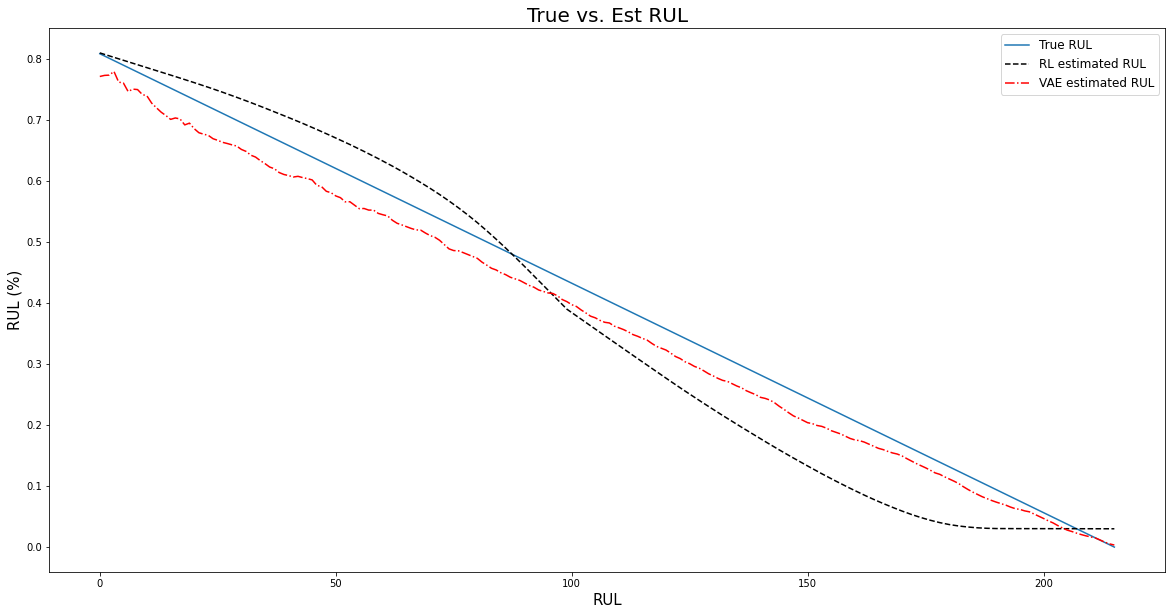

In [77]:
# '''
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

plt.plot(test_engine_df['NormTime'],label="True RUL")
plt.plot(eval_df['NormTime'].iloc[:steps_to_go], color='black', ls='--', label="RL estimated RUL")
plt.plot(test_engine_decoded_df['NormTime'].iloc[:steps_to_go], color='red', ls='-.', label="VAE estimated RUL")
plt.legend(prop={'size': 12})
plt.title('True vs. Est RUL', size=20)
plt.xlabel('RUL', size=15)
plt.ylabel('RUL (%)', size=15)


In [62]:
ray.shutdown()